# Main Script Mel GAN

### Imports

In [22]:
try: 
    import librosa
except:
    !pip install librosa


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from torch.nn.utils import weight_norm
import torch.optim as optim


# Utils
import numpy as np
from numpy import ndarray
import logging, librosa
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config

### General

In [23]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "MelGan_v2"
training_data_name: str = "training_full_mel"
training_label_name: str = "training_full_wave"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [24]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [25]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 2496 // 2
batch_size: int = 48
tensor_wave_dim: list = [batch_size, 1, 2**17] #B, C, H = Batch, channels, Time domain
tensor_mel_dim: list = [batch_size, 96, 512]
learning_rate: float = 1e-4
epochs: int = 300
restart_training: bool = True
checkpoint_freq: int = 5
num_workers: int = 4


### Data Loading

In [26]:
mel_data: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
audio_data: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_label_name + ".npy"), remote_kernel))

np.random.seed(50)
indicies: ndarray = np.arange(mel_data.shape[0])
np.random.shuffle(indicies)
mel_data = mel_data[indicies]
audio_data = audio_data[indicies]


data_loader = create_dataloader(Audio_Data(mel_data[:n_training_samples], audio_data[:n_training_samples]), batch_size, num_workers)


### Model Self imp

In [27]:
class Mel2Wave(nn.Module):
    def __init__(self, in_channels: int, intermediate_channels: int = 512) -> None:
        super(Mel2Wave, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, intermediate_channels, kernel_size=7, stride=1, padding=3),
            
            Upsample(in_channels=intermediate_channels, out_channels=intermediate_channels // 2, factor=8),
            ResStack(channels=intermediate_channels // 2),

            Upsample(in_channels=intermediate_channels // 2, out_channels=intermediate_channels // 4, factor=8),
            ResStack(channels=intermediate_channels // 4),

            Upsample(in_channels=intermediate_channels // 4, out_channels=intermediate_channels // 8, factor=2),
            ResStack(channels=intermediate_channels // 8),

            Upsample(in_channels=intermediate_channels // 8, out_channels=intermediate_channels // 16, factor=2),
            ResStack(channels=intermediate_channels // 16),

            nn.Conv1d(intermediate_channels // 16, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    def forward(self, x: Tensor) -> Tensor:
        return self.block(x)

class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, factor: int) -> None:
        super(Upsample, self).__init__()
        kernel_size = factor * 2
        stride = factor
        padding = factor // 2 + factor % 2
        output_padding = factor % 2
        self.block = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x: Tensor) -> Tensor:
        return self.block(x)

class DilConv(nn.Module):
    def __init__(self, channels: int, dilation: int) -> None:
        super(DilConv, self).__init__()
        self.block = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation),
            nn.LeakyReLU(0.2),
            nn.Conv1d(channels, channels, kernel_size=1)
        )
    def forward(self, x: Tensor) -> Tensor:
        return x + self.block(x)

class ResStack(nn.Module):
    def __init__(self, channels: int) -> None:
        super(ResStack, self).__init__()
        self.block = nn.Sequential(
            DilConv(channels, 1),
            DilConv(channels, 3),
            DilConv(channels, 9)
        )
    def forward(self, x: Tensor) -> Tensor:
        return self.block(x)

class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels: int = 1, channels: int = 16) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, channels, kernel_size=15, stride=1, padding=7),
            nn.LeakyReLU(0.2),

            nn.Conv1d(channels, channels*4, kernel_size=41, stride=4, padding=20, groups=4),
            nn.LeakyReLU(0.2),

            nn.Conv1d(channels*4, channels*8, kernel_size=41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),

            nn.Conv1d(channels*8, channels*16, kernel_size=41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),

            nn.Conv1d(channels*16, channels*16, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2),

            nn.Conv1d(channels*16, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x: Tensor) -> tuple[Tensor,...]:
        feature_maps = []
        for layer in self.block:
            x = layer(x)
            if isinstance(layer, nn.Conv1d):
                feature_maps.append(x)
        return x, feature_maps

class MultiScaleDiscriminator(nn.Module):
    def __init__(self, in_channels: int = 1, channels: int = 16) -> None:
        super().__init__()
        self.pooling = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)
        self.discriminators = nn.ModuleList([
            DiscriminatorBlock(in_channels, channels),
            DiscriminatorBlock(in_channels, channels),
            DiscriminatorBlock(in_channels, channels),
        ])

    def forward(self, x: Tensor) -> tuple[Tensor, ...]:
        outputs = []
        feature_maps = []
        for disc in self.discriminators:
            out, fmap = disc(x)
            outputs.append(out)
            feature_maps.append(fmap)
            x = self.pooling(x)
        return outputs, feature_maps


In [28]:
generator = Mel2Wave(in_channels=96, intermediate_channels=512).to(device)
discriminator=MultiScaleDiscriminator(in_channels=1, channels=16).to(device)

In [ ]:
gen_optim = optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
disc_optim = optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
gen_lr_scheduler = None #optim.lr_scheduler.CosineAnnealingLR(gen_optim, T_max=300, eta_min=1e-8)
disc_lr_scheduler = None #optim.lr_scheduler.CosineAnnealingLR(disc_optim, T_max=300, eta_min=1e-8)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    generator.load_state_dict(model["generator"])
    discriminator.load_state_dict(model["discriminator"])
    if not restart_training:
        gen_optim.load_state_dict(model["gen_optim"])
        disc_optim.load_state_dict(model["disc_optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(generator)} and {count_parameters(discriminator)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(generator)} and {count_parameters(discriminator)} Parameters")

In [ ]:
adversarial_loss = nn.MSELoss()
l1_loss = nn.L1Loss(reduction="mean")

recon_loss_weight: float = 0
fm_loss_weight: float = 10.0
label_smooth_val: float = 0
recon_inc_fact: float = 1

n_gen_updates: int = 1
n_disc_updates: int = 1

In [ ]:
logger.info(f"Training started on {device}")
scaler = torch.cuda.amp.GradScaler()
loss_d_list: list = []
loss_g_list: list = []
total_time: float = 0.0

for e in range(0, epochs):
    total_d_loss: float = 0
    total_g_loss: float = 0
    start_time: float = time.time()

    for b_idx, (mel, audio) in enumerate(data_loader):
            mel, audio = mel.to(device), audio.to(device).unsqueeze(1)
            for _ in range(n_disc_updates):
                with torch.autocast(device_type=device):
                    fake_waveform = generator(mel).detach()
                    real_preds, _ = discriminator(audio)
                    fake_preds, _ = discriminator(fake_waveform)
                
                d_loss = 0
                for real_pred, fake_pred in zip(real_preds, fake_preds):
                    d_loss += torch.mean(torch.clamp(1 - real_pred, min=0))
                    d_loss += torch.mean(torch.clamp(1 + fake_pred, min=0))
                
                disc_optim.zero_grad()
                scaler.scale(d_loss).backward()
                scaler.step(disc_optim)
                scaler.update()

                total_d_loss += d_loss.item()
                if np.isnan(d_loss.item()):
                    logger.info("Breaking due to NaN Discriminator loss.")
                    break

            for _ in range(n_gen_updates):
                with torch.autocast(device_type=device):
                    fake_waveform = generator(mel)
                    fake_preds, fake_feats = discriminator(fake_waveform)
                    _, real_feats = discriminator(audio)
                
                g_adv_loss = 0
                for fake_pred in fake_preds:
                    g_adv_loss += -torch.mean(fake_pred)

                fm_loss = 0
                num_fmaps = 0
                for real_fmaps, fake_fmaps in zip(real_feats, fake_feats):
                    for real_fmap, fake_fmap in zip(real_fmaps, fake_fmaps):
                        Ni = real_fmap.numel() / real_fmap.size(0)
                        fm_loss += l1_loss(fake_fmap, real_fmap.detach()) / Ni
                        num_fmaps += 1
                fm_loss = fm_loss / num_fmaps

                recon_loss = l1_loss(fake_waveform, audio)
                g_loss = g_adv_loss + fm_loss_weight * fm_loss + recon_loss_weight * recon_loss

                gen_optim.zero_grad()
                scaler.scale(g_loss).backward()
                scaler.step(gen_optim)
                scaler.update()

                total_g_loss += g_loss.item()
                if np.isnan(g_loss.item()):
                    logger.info("Breaking due to NaN Generator loss.")
                    break

            if logger.getEffectiveLevel() == LIGHT_DEBUG:
                current_batch = b_idx + 1
                print(f"\r{time.strftime('%Y-%m-%d %H:%M:%S')},000 - LIGHT_DEBUG - Batch {current_batch:03d}/{len(data_loader):03d} D/G Loss: {d_loss.item():.3f} {g_loss.item():.3f}", end='', flush=True)
    else:
        if logger.getEffectiveLevel() == LIGHT_DEBUG:
            print(flush=True)

        avg_d_loss = total_d_loss / len(data_loader)
        avg_g_loss = total_g_loss / len(data_loader)
        loss_d_list.append(avg_d_loss)
        loss_g_list.append(avg_g_loss)
        if gen_lr_scheduler is not None:
            gen_lr_scheduler.step()
        if disc_lr_scheduler is not None:
            disc_lr_scheduler.step()
        recon_loss_weight = recon_loss_weight * recon_inc_fact


        epoch_time = time.time() - start_time
        total_time += epoch_time
        remaining_time = int((total_time / (e + 1)) * (epochs - e - 1))

        logger.info(f"Epoch {e + 1:03d}: Avg. D/G Loss: {avg_d_loss:.4e}, {avg_g_loss:.4e} Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {gen_optim.param_groups[0]['lr']:.5e} ")
        
        if checkpoint_freq > 0 and (e + 1) % checkpoint_freq == 0:
            checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1:03d}.pth"
            torch.save({"generator": generator.state_dict(), "discriminator": discriminator.state_dict(), "gen_optim": gen_optim.state_dict(), "disc_optim": disc_optim.state_dict() , "epoch": e + 1}, checkpoint_path)
            if e + 1 != checkpoint_freq:
                last_path: str = f"{full_model_path[:-4]}_epoch_{(e + 1) - checkpoint_freq:03d}.pth"
                del_if_exists(last_path)
            logger.light_debug(f"Checkpoint saved model to {checkpoint_path}")
        continue
    break


torch.save({"generator": generator.state_dict(), "discriminator": discriminator.state_dict(), "gen_optim": gen_optim.state_dict(), "disc_optim": disc_optim.state_dict() , "epoch": e + 1}, full_model_path)

logger.light_debug(f"Saved model to {full_model_path}")

if checkpoint_freq > 0:
    checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1 - ((e + 1) % checkpoint_freq):03d}.pth"
    del_if_exists(checkpoint_path)

scatter_plot(loss_d_list)
scatter_plot(loss_g_list)

### Original Impl

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def WNConv1d(*args, **kwargs):
    return weight_norm(nn.Conv1d(*args, **kwargs))


def WNConvTranspose1d(*args, **kwargs):
    return weight_norm(nn.ConvTranspose1d(*args, **kwargs))


class ResnetBlock(nn.Module):
    def __init__(self, dim, dilation=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ReflectionPad1d(dilation),
            WNConv1d(dim, dim, kernel_size=3, dilation=dilation),
            nn.LeakyReLU(0.2),
            WNConv1d(dim, dim, kernel_size=1),
        )
        self.shortcut = WNConv1d(dim, dim, kernel_size=1)

    def forward(self, x):
        return self.shortcut(x) + self.block(x)


class Generator(nn.Module):
    def __init__(self, input_size, ngf, n_residual_layers):
        super().__init__()
        ratios = [8, 8, 2, 2]
        self.hop_length = np.prod(ratios)
        mult = int(2 ** len(ratios))

        model = [
            nn.ReflectionPad1d(3),
            WNConv1d(input_size, mult * ngf, kernel_size=7, padding=0),
        ]

        # Upsample to raw audio scale
        for i, r in enumerate(ratios):
            model += [
                nn.LeakyReLU(0.2),
                WNConvTranspose1d(
                    mult * ngf,
                    mult * ngf // 2,
                    kernel_size=r * 2,
                    stride=r,
                    padding=r // 2 + r % 2,
                    output_padding=r % 2,
                ),
            ]

            for j in range(n_residual_layers):
                model += [ResnetBlock(mult * ngf // 2, dilation=3 ** j)]

            mult //= 2

        model += [
            nn.LeakyReLU(0.2),
            nn.ReflectionPad1d(3),
            WNConv1d(ngf, 1, kernel_size=7, padding=0),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)


class NLayerDiscriminator(nn.Module):
    def __init__(self, ndf, n_layers, downsampling_factor):
        super().__init__()
        model = nn.ModuleDict()

        model["layer_0"] = nn.Sequential(
            nn.ReflectionPad1d(7),
            WNConv1d(1, ndf, kernel_size=15),
            nn.LeakyReLU(0.2, True),
        )

        nf = ndf
        stride = downsampling_factor
        for n in range(1, n_layers + 1):
            nf_prev = nf
            nf = min(nf * stride, 1024)

            model["layer_%d" % n] = nn.Sequential(
                WNConv1d(
                    nf_prev,
                    nf,
                    kernel_size=stride * 10 + 1,
                    stride=stride,
                    padding=stride * 5,
                    groups=nf_prev // 4,
                ),
                nn.LeakyReLU(0.2, True),
            )

        nf = min(nf * 2, 1024)
        model["layer_%d" % (n_layers + 1)] = nn.Sequential(
            WNConv1d(nf_prev, nf, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2, True),
        )

        model["layer_%d" % (n_layers + 2)] = WNConv1d(
            nf, 1, kernel_size=3, stride=1, padding=1
        )

        self.model = model

    def forward(self, x):
        results = []
        for key, layer in self.model.items():
            x = layer(x)
            results.append(x)
        return results


class Discriminator(nn.Module):
    def __init__(self, num_D, ndf, n_layers, downsampling_factor):
        super().__init__()
        self.model = nn.ModuleDict()
        for i in range(num_D):
            self.model[f"disc_{i}"] = NLayerDiscriminator(
                ndf, n_layers, downsampling_factor
            )

        self.downsample = nn.AvgPool1d(4, stride=2, padding=1, count_include_pad=False)
        self.apply(weights_init)

    def forward(self, x):
        results = []
        for key, disc in self.model.items():
            results.append(disc(x))
            x = self.downsample(x)
        return results

In [31]:
generator = Generator(input_size=96, ngf=32, n_residual_layers=3).to(device)
discriminator = Discriminator(num_D=3, ndf=16, n_layers=4, downsampling_factor=4).to(device)

In [32]:
gen_optim = optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
disc_optim = optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
gen_lr_scheduler = None #optim.lr_scheduler.CosineAnnealingLR(gen_optim, T_max=300, eta_min=1e-8)
disc_lr_scheduler = None #optim.lr_scheduler.CosineAnnealingLR(disc_optim, T_max=300, eta_min=1e-8)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    generator.load_state_dict(model["generator"])
    discriminator.load_state_dict(model["discriminator"])
    if not restart_training:
        gen_optim.load_state_dict(model["gen_optim"])
        disc_optim.load_state_dict(model["disc_optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(generator)} and {count_parameters(discriminator)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(generator)} and {count_parameters(discriminator)} Parameters")

2025-06-10 08:03:29,828 - INFO - Model MelGan_v2 loaded with ~4.323M and ~16.92M Parameters


In [33]:
n_d_lay: int = 4
n_d: int = 3
n_gen_updates: int = 1
n_disc_updates: int = 1
fm_loss_weight: float = 10.0
torch.backends.cudnn.benchmark = True

2025-06-10 08:03:35,090 - INFO - Training started on cuda
2025-06-10 08:04:22,685 - INFO - Epoch 001: Avg. D/G Loss: 4.6874e+00, 9.0485e+00 Remaining Time: 03h 57min 10s LR: 1.00000e-04 
2025-06-10 08:04:55,603 - INFO - Epoch 002: Avg. D/G Loss: 4.7412e+00, 8.6270e+00 Remaining Time: 03h 19min 56s LR: 1.00000e-04 
2025-06-10 08:05:28,637 - INFO - Epoch 003: Avg. D/G Loss: 4.6095e+00, 8.9570e+00 Remaining Time: 03h 07min 20s LR: 1.00000e-04 
2025-06-10 08:06:01,689 - INFO - Epoch 004: Avg. D/G Loss: 4.4685e+00, 9.5900e+00 Remaining Time: 03h 00min 47s LR: 1.00000e-04 
2025-06-10 08:06:34,777 - INFO - Epoch 005: Avg. D/G Loss: 4.1009e+00, 9.7662e+00 Remaining Time: 02h 56min 41s LR: 1.00000e-04 
2025-06-10 08:07:08,083 - INFO - Epoch 006: Avg. D/G Loss: 3.9562e+00, 9.7671e+00 Remaining Time: 02h 53min 43s LR: 1.00000e-04 
2025-06-10 08:07:41,166 - INFO - Epoch 007: Avg. D/G Loss: 4.8579e+00, 1.0070e+01 Remaining Time: 02h 51min 28s LR: 1.00000e-04 
2025-06-10 08:08:14,252 - INFO - Epoch 

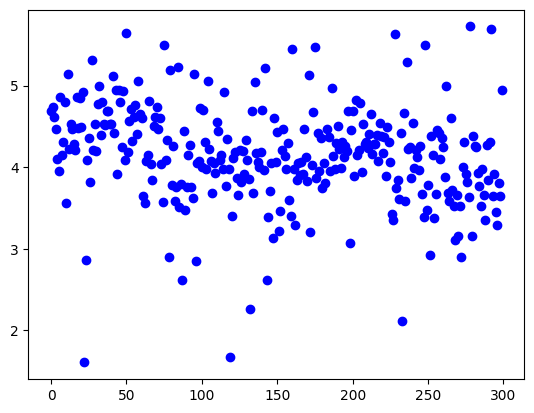

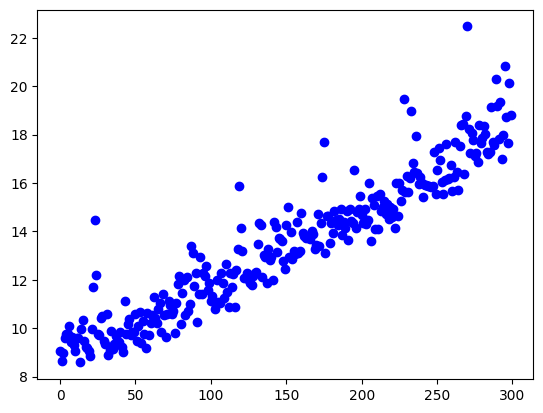

In [34]:
logger.info(f"Training started on {device}")
scaler = torch.cuda.amp.GradScaler()
loss_d_list: list = []
loss_g_list: list = []
total_time: float = 0.0
best_mel_reconst = float('inf')

for e in range(0, epochs):
    total_d_loss: float = 0
    total_g_loss: float = 0
    start_time: float = time.time()

    for b_idx, (mel, audio) in enumerate(data_loader):
            mel, audio = mel.to(device), audio.to(device).unsqueeze(1)
            for _ in range(n_disc_updates):
                with torch.autocast(device_type=device):
                    fake_waveform = generator(mel).detach()
                    real_preds = discriminator(audio)
                    fake_preds = discriminator(fake_waveform)
                
                d_loss = 0
                for real_pred, fake_pred in zip(real_preds, fake_preds):
                    d_loss += torch.nn.functional.relu(1 - real_pred[-1]).mean()
                    d_loss += torch.nn.functional.relu(1 + fake_pred[-1]).mean()
                
                disc_optim.zero_grad()
                scaler.scale(d_loss).backward()
                scaler.step(disc_optim)
                scaler.update()

                total_d_loss += d_loss.item()
                if np.isnan(d_loss.item()):
                    logger.info("Breaking due to NaN Discriminator loss.")
                    break

            for _ in range(n_gen_updates):
                with torch.autocast(device_type=device):
                    fake_waveform = generator(mel)
                    fake_feats = discriminator(fake_waveform)
                    real_feats = discriminator(audio)
                
                g_adv_loss = 0
                for fake_pred in fake_feats:
                    g_adv_loss += -fake_pred[-1].mean()

                feat_weights = 4.0 / (n_d_lay + 1)
                d_weights = 1.0 / n_d
                wt = d_weights * feat_weights
                feat_loss = 0
                for i in range(n_d):
                    for j in range(len(fake_feats[i]) - 1):
                        feat_loss += wt * nn.functional.l1_loss(fake_feats[i][j], real_feats[i][j].detach())
                
                g_loss = g_adv_loss + fm_loss_weight * feat_loss


                gen_optim.zero_grad()
                scaler.scale(g_loss).backward()
                scaler.step(gen_optim)
                scaler.update()

                total_g_loss += g_loss.item()
                if np.isnan(g_loss.item()):
                    logger.info("Breaking due to NaN Generator loss.")
                    break

            if logger.getEffectiveLevel() == LIGHT_DEBUG:
                current_batch = b_idx + 1
                print(f"\r{time.strftime('%Y-%m-%d %H:%M:%S')},000 - LIGHT_DEBUG - Batch {current_batch:03d}/{len(data_loader):03d} D/G Loss: {d_loss.item():.3f} {g_loss.item():.3f}", end='', flush=True)
    else:
        if logger.getEffectiveLevel() == LIGHT_DEBUG:
            print(flush=True)

        avg_d_loss = total_d_loss / len(data_loader)
        avg_g_loss = total_g_loss / len(data_loader)
        loss_d_list.append(avg_d_loss)
        loss_g_list.append(avg_g_loss)
        if gen_lr_scheduler is not None:
            gen_lr_scheduler.step()
        if disc_lr_scheduler is not None:
            disc_lr_scheduler.step()


        epoch_time = time.time() - start_time
        total_time += epoch_time
        remaining_time = int((total_time / (e + 1)) * (epochs - e - 1))

        logger.info(f"Epoch {e + 1:03d}: Avg. D/G Loss: {avg_d_loss:.4e}, {avg_g_loss:.4e} Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {gen_optim.param_groups[0]['lr']:.5e} ")
        
        if checkpoint_freq > 0 and (e + 1) % checkpoint_freq == 0:
            checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1:03d}.pth"
            torch.save({"generator": generator.state_dict(), "discriminator": discriminator.state_dict(), "gen_optim": gen_optim.state_dict(), "disc_optim": disc_optim.state_dict() , "epoch": e + 1}, checkpoint_path)
            if e + 1 != checkpoint_freq:
                last_path: str = f"{full_model_path[:-4]}_epoch_{(e + 1) - checkpoint_freq:03d}.pth"
                del_if_exists(last_path)
            logger.light_debug(f"Checkpoint saved model to {checkpoint_path}")
        continue
    break


torch.save({"generator": generator.state_dict(), "discriminator": discriminator.state_dict(), "gen_optim": gen_optim.state_dict(), "disc_optim": disc_optim.state_dict() , "epoch": e + 1}, full_model_path)

logger.light_debug(f"Saved model to {full_model_path}")

if checkpoint_freq > 0:
    checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1 - ((e + 1) % checkpoint_freq):03d}.pth"
    del_if_exists(checkpoint_path)

scatter_plot(loss_d_list)
scatter_plot(loss_g_list)

### Convert to wave

In [35]:
file_idx: int = 4000
with torch.no_grad():
    generated_wave = generator(torch.tensor(mel_data[file_idx]).unsqueeze(0).to(device))
save_audio_file(generated_wave.cpu().numpy()[0,0], "test3.wav", 32000)
#save_audio_file(librosa.feature.inverse.mel_to_audio(mel_data[file_idx], n_fft=1023, hop_length=256, sr=32000), "test_gl.wav", 32000)
#save_audio_file(audio_data[file_idx], "test_real.wav", 32000)

In [36]:
spect = load_spectrogram("spect.npz")
with torch.no_grad():
    generated_wave = generator(torch.tensor(spect).unsqueeze(0).to(device))
save_audio_file(generated_wave.cpu().numpy()[0,0], "muGen_out2.wav", 32000)
save_audio_file(librosa.feature.inverse.mel_to_audio(spect, n_fft=1023, hop_length=256, sr=32000), "muGen_out1_gl.wav", 32000)